In [1]:
import os, sys, time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
import matplotlib.patheffects as patheffects
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.io import fits
from astropy.visualization import (AsinhStretch, LinearStretch, ImageNormalize)

from gofish import imagecube  # for the CLEAN profile
sys.path.append('../frank_fit')
import diskdictionary as disk
from myutils import Jybeam_to_Jysr, Jysr_to_Tb, Jysr_to_Tb_err, Jysr_to_Tb_RJ, Jysr_to_Tb_RJ_err

from scipy.integrate import simpson
from scipy.signal import find_peaks

arcsec = 1/3600 * np.pi/180
deg = np.pi/180

In [2]:
##### MODIFY HERE #####

target = 'AA_Tau'
target_label = disk.disk[target]['label']

robust = -0.5

lim = 2.2    # arcsec, maximum radius of the profile to be plotted
maj_ticks = 0.5          # arcsec, spacing of the major ticks in figures
min_ticks = maj_ticks/5  # arcsec, spacing of the minor ticks in figures
FOV_gofish = 5     # Clip the image cube down to a specific field-of-view spanning a range ``FOV``, where ``FOV`` is in [arcsec]
dr_gofish = None     #  Width of the annuli to split the integrated region into in [arcsec]. Default is quater of the beam major axis


# load data
data_fits = f'../frank_fit/CLEAN/robust{robust}/{target}_data_robust{robust}.fits'
dhdu = fits.open(data_fits)
dimg, hd = np.squeeze(dhdu[0].data), dhdu[0].header
freq = hd['CRVAL3']

bmaj, bmin, bPA = 3600 * hd['BMAJ'], 3600 * hd['BMIN'], hd['BPA']
beam_area = (np.pi * bmaj * bmin / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

distance_pc = disk.disk[target]['distance']

In [3]:
#############################
### Plot the radial profile
############################

# Obtain the CLEAN profile using the imagecube function from gofish
cube = imagecube(data_fits, FOV=FOV_gofish)

r_clean, I_clean, dI_clean = cube.radial_profile(x0=disk.disk[target]['dx'], y0=disk.disk[target]['dy'], inc=disk.disk[target]['incl'], PA=disk.disk[target]['PA'], dr=dr_gofish)
def _calculate_flux_jy_sr(data,bmin,bmaj):
    omega = np.radians(bmin / 3600.)
    omega *= np.radians(bmaj / 3600.)
    beam_area = np.pi * omega / 4. / np.log(2.)
    return data / beam_area

I_clean_b  = _calculate_flux_jy_sr( I_clean,cube.bmin,cube.bmaj)
dI_clean_b = _calculate_flux_jy_sr(dI_clean,cube.bmin,cube.bmaj)

r_clean_au =  r_clean * distance_pc
Tb_clean, dTb_clean = Jysr_to_Tb_err(Jybeam_to_Jysr(I_clean, bmin, bmaj), Jybeam_to_Jysr(dI_clean, bmin, bmaj), freq)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


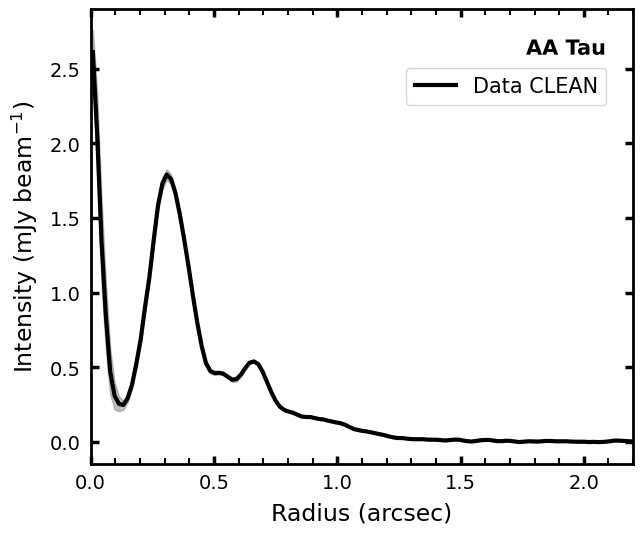

In [4]:
fig = plt.figure(figsize=(7, 5.9))
ax = fig.add_subplot(111)

ax.fill_between(r_clean, (I_clean-dI_clean)*1e3, (I_clean+dI_clean)*1e3, color='gray', alpha=0.5)
ax.plot(r_clean, I_clean*1e3, 'k', lw=3, label='Data CLEAN')

ax.text(0.95, 0.9, s=target_label,ha='right',
        transform=ax.transAxes, color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])
ax.legend(fontsize=15, bbox_to_anchor=(0.97, 0.83), loc='right')

ax.set_xlim([0, lim])
ax.xaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(min_ticks))

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=7,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=7,width=1.5, length=4,direction='in',color='k')
ax.set_xlabel('Radius (arcsec)', fontsize = 17, labelpad=7)
ax.set_ylabel('Intensity (mJy beam$^{-1}$)', fontsize = 17, labelpad=7)

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2) 

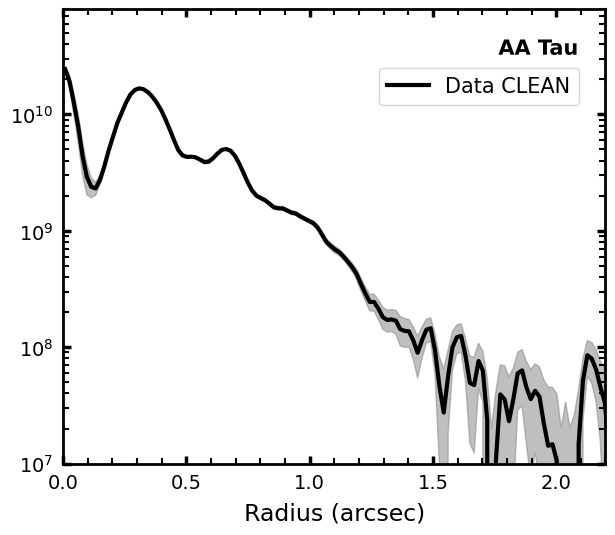

In [8]:
fig = plt.figure(figsize=(7, 5.9))
ax = fig.add_subplot(111)

ax.fill_between(r_clean, I_clean_b-dI_clean_b, I_clean_b+dI_clean_b, color='gray', alpha=0.5)
ax.plot(r_clean, I_clean_b, 'k', lw=3, label='Data CLEAN')

ax.text(0.95, 0.9, s=target_label,ha='right',
        transform=ax.transAxes, color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])
ax.legend(fontsize=15, bbox_to_anchor=(0.97, 0.83), loc='right')

ax.set_yscale('log')
ymin=1e7
ymax=8e10
ax.set_ylim([ymin, ymax]) 

ax.set_xlim([0, lim])
ax.xaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(min_ticks))

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=7,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=7,width=1.5, length=4,direction='in',color='k')
ax.set_xlabel('Radius (arcsec)', fontsize = 17, labelpad=7)

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2) 

In [10]:
# CLEAN profile
np.savetxt(f'{target}_CLEAN_profile_robust{robust}.txt',
           np.column_stack([r_clean, r_clean_au, I_clean*1e3, dI_clean*1e3, Tb_clean, dTb_clean, Jybeam_to_Jysr(I_clean, bmin, bmaj), Jybeam_to_Jysr(dI_clean, bmin, bmaj)]),
           fmt='%10.6e', delimiter='\t',
           header=f'Intensity radial profile from the CLEAN image of {target} with robust={robust}\nThe brightness temperature is computed using the full Planck law\nColumns:\tR(arcsec)\tR(au)\tIntensity(mJy/beam)\td_Intensity(mJy/beam)\tBrightness_temperature(K)\td_Brightness_temperature(K)\tIntensity(Jy/sr)\td_Intensity(Jy/sr)')

# Compute radii

In [ ]:
integrand  = 2*np.pi*r_clean*arcsec*Jybeam_to_Jysr(I_clean, bmin, bmaj)

tot_flux =  simpson(integrand, r_clean*arcsec) * np.cos(disk.disk[target]['incl']*deg) *1e3
print(f'Total flux from all radii from CLEAN profile = {tot_flux:.2f} mJy')

In [ ]:
cumulative_flux_mJy = np.zeros(integrand.shape[0])

for i in range(1, integrand.shape[0]):
    # Integrate from center (0) to radius (i)
    # Result is converted to mJy and corrected for inclination
    cumulative_flux_mJy[i] = simpson(integrand[:i], r_clean[:i]*arcsec) * np.cos(disk.disk[target]['incl']*deg) * 1e3

RMS_data = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[5]  # in mJy

beam_area_arcsec2 = (np.pi * bmaj * bmin) / (4 * np.log(2))
n_beams = (np.pi * r_clean**2) / beam_area_arcsec2
cumulative_err_mJy = (RMS_data * np.sqrt(n_beams))  # * sqrt(n_beams) is the uncertainty of the cumulative

In [ ]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot()

ax.plot(r_clean, cumulative_flux_mJy, color='k', linewidth=3, label='Cumulative Flux')

ax.fill_between(r_clean,
                cumulative_flux_mJy - cumulative_err_mJy,
                cumulative_flux_mJy + cumulative_err_mJy,
                color='k', alpha=0.15, label='Uncertainty')

ax.text(0.95, 0.9, s=target_label,ha='right',
        transform=ax.transAxes, color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

index_xticks = 0.5
ax.xaxis.set_major_locator(MultipleLocator(index_xticks))
ax.xaxis.set_minor_locator(MultipleLocator(index_xticks/5))

index_yticks = 5
ax.yaxis.set_major_locator(MultipleLocator(index_yticks))
ax.yaxis.set_minor_locator(MultipleLocator(index_yticks/5))

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=16, pad=10,width=2.5, length=5,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=16, pad=10,width=1.5, length=3,direction='in',color='k')

ax.set_xlabel('Radius (arcsec)', fontsize = 18, labelpad=10)
ax.set_ylabel('Cumulative flux (mJy)', fontsize = 18, labelpad=10)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)  

In [ ]:
# --- Run Method 1: First Peak  ---
peaks, _ = find_peaks(cumulative_flux_mJy)
if len(peaks) > 0:
    idx_first = peaks[0]
else:
    idx_first = np.argmax(cumulative_flux_mJy) # fallback if monotonic

r_first = r_clean[idx_first]
flux_first = cumulative_flux_mJy[idx_first]


# --- 3. Run Method 2: Global Max ---
# search for max within 90% of FOV to avoid edge noise
limit_idx = np.abs(r_clean - r_clean.max()*0.9).argmin()
idx_global = np.argmax(cumulative_flux_mJy[:limit_idx])

r_global = r_clean[idx_global]
flux_global = cumulative_flux_mJy[idx_global]

print("--- Comparison of Methods ---")
print(f"First Peak: R={r_first:.3f}\", F={flux_first:.2f} mJy")
print(f"Global Max: R={r_global:.3f}\", F={flux_global:.2f} mJy")

In [ ]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot()

ax.plot(r_clean, cumulative_flux_mJy, color='k', linewidth=3)

ax.fill_between(r_clean,
                cumulative_flux_mJy - cumulative_err_mJy,
                cumulative_flux_mJy + cumulative_err_mJy,
                color='k', alpha=0.15)

ax.text(0.95, 0.9, s=target_label,ha='right',
        transform=ax.transAxes, color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])


# --- Mark Method 1: First Peak ---
ax.axvline(r_first, linestyle='--', color='blue', linewidth=1.5, label='First Peak')
ax.axhline(flux_first, linestyle='--', color='blue', linewidth=1.5)

# --- Mark Method 2: Global Max ---
ax.axvline(r_global, linestyle=':', color='red', linewidth=1.5, label='Global Max')
ax.axhline(flux_global, linestyle=':', color='red', linewidth=1.5)

ax.legend(fontsize=12)

index_xticks = 0.5
ax.xaxis.set_major_locator(MultipleLocator(index_xticks))
ax.xaxis.set_minor_locator(MultipleLocator(index_xticks/5))

index_yticks = 5
ax.yaxis.set_major_locator(MultipleLocator(index_yticks))
ax.yaxis.set_minor_locator(MultipleLocator(index_yticks/5))

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=16, pad=10,width=2.5, length=5,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=16, pad=10,width=1.5, length=3,direction='in',color='k')

ax.set_xlabel('Radius (arcsec)', fontsize = 18, labelpad=10)
ax.set_ylabel('Cumulative flux (mJy)', fontsize = 18, labelpad=10)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)  

In [ ]:
# --- SELECT YOUR CHOSEN METHOD HERE ---
selected_method = 'global_max'  # or 'first_peak'

if selected_method == 'first_peak':
    r_cog, flux_cog = r_first, flux_first
    idx_cog = idx_first
else:
    r_cog, flux_cog = r_global, flux_global
    idx_cog = idx_global

print(f"Selected Method: {selected_method}")
print(f"Final R_CoG: {r_cog:.3f} arcsec")
print(f"Final Flux : {flux_cog:.2f} mJy")

# normalize the cumulative curve by the SELECTED CoG flux
mask_source = r_clean <= r_cog
r_source = r_clean[mask_source]
norm_flux = cumulative_flux_mJy[mask_source] / flux_cog

# find indices for R68, R90, R95
idx_68 = np.abs(norm_flux - 0.68).argmin()
idx_90 = np.abs(norm_flux - 0.90).argmin()
idx_95 = np.abs(norm_flux - 0.95).argmin()

R_68_arcsec = r_source[idx_68]
R_90_arcsec = r_source[idx_90]
R_95_arcsec = r_source[idx_95]

R_68_au = R_68_arcsec * distance_pc
R_90_au = R_90_arcsec * distance_pc
R_95_au = R_95_arcsec * distance_pc

# compute uncertainties on radii
# sigma_R = sigma_F / slope
def get_radius_error(idx_val):
    slope = integrand[idx_val] * arcsec * np.cos(disk.disk[target]['incl']*deg) * 1e3 
    if slope < 1e-6: return 0.0
    return cumulative_err_mJy[idx_val] / slope

dR_68 = get_radius_error(idx_68)
dR_90 = get_radius_error(idx_90)
dR_95 = get_radius_error(idx_95)

# compute uncertainties in AU
dR_68_au = dR_68 * distance_pc
dR_90_au = dR_90 * distance_pc
dR_95_au = dR_95 * distance_pc

print(f"R_68 = {R_68_arcsec:.3f} +/- {dR_68:.3f} arcsec = {R_68_arcsec*distance_pc:.1f} +/- {dR_68_au:.1f} au ")
print(f"R_90 = {R_90_arcsec:.3f} +/- {dR_90:.3f} arcsec = {R_90_arcsec*distance_pc:.1f} +/- {dR_90_au:.1f} au ")
print(f"R_95 = {R_95_arcsec:.3f} +/- {dR_95:.3f} arcsec = {R_95_arcsec*distance_pc:.1f} +/- {dR_95_au:.1f} au ")

In [ ]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot()

ax.plot(r_clean, cumulative_flux_mJy, color='k', linewidth=3, label='Cumulative Flux')

ax.fill_between(r_clean,
                cumulative_flux_mJy - cumulative_err_mJy,
                cumulative_flux_mJy + cumulative_err_mJy,
                color='k', alpha=0.15, label='Uncertainty')

ax.text(0.95, 0.9, s=target_label,ha='right',
        transform=ax.transAxes, color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

# mark CoG radius and flux
ax.axvline(r_cog, linestyle=':', color='r', linewidth=1.5)
ax.axhline(flux_cog, linestyle=':', color='r', linewidth=1.5)

ax.vlines((R_68_arcsec, R_90_arcsec, R_95_arcsec), 0, 1000, linestyle='dashed', color='gray', linewidth=1.5)


# figure style
ax.text(0.95, 0.05, s=target_label, ha='right', transform=ax.transAxes, 
        color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

index_xticks = 0.5
if r_cog < 0.5: index_xticks = 0.1
ax.xaxis.set_major_locator(MultipleLocator(index_xticks))
ax.xaxis.set_minor_locator(MultipleLocator(index_xticks/5))

index_yticks = 50
if flux_cog < 50: index_yticks = 10
ax.yaxis.set_major_locator(MultipleLocator(index_yticks))
ax.yaxis.set_minor_locator(MultipleLocator(index_yticks/5))

ax.set_xlim(0, r_cog * 2.0)
ax.set_ylim(0, flux_cog * 1.3)

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=16, pad=10,width=2.5, length=5,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=16, pad=10,width=1.5, length=3,direction='in',color='k')

ax.set_xlabel('Radius (arcsec)', fontsize = 18, labelpad=10)
ax.set_ylabel('Cumulative flux (mJy)', fontsize = 18, labelpad=10)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2) 

In [ ]:
fig = plt.figure(figsize=(7, 5.9))
ax = fig.add_subplot(111)

ax.fill_between(r_clean, I_clean_b-dI_clean_b, I_clean_b+dI_clean_b, color='gray', alpha=0.5)
ax.plot(r_clean, I_clean_b, 'k', lw=3, label='Data CLEAN')

ax.text(0.95, 0.9, s=target_label,ha='right',
        transform=ax.transAxes, color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])
ax.legend(fontsize=15, bbox_to_anchor=(0.97, 0.83), loc='right')

ax.set_yscale('log')
ymin=1e7
ymax=8e11
ax.set_ylim([ymin, ymax]) 

# mark CoG radius and flux
ax.axvline(r_cog, linestyle=':', color='r', linewidth=1.5)
ax.axhline(flux_cog, linestyle=':', color='r', linewidth=1.5)

ax.vlines((R_68_arcsec, R_90_arcsec, R_95_arcsec), 0, 1e15, linestyle='dashed', color='gray', linewidth=1.5)


ax.set_xlim([0, r_cog * 2.0])
ax.xaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(min_ticks))

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=7,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=7,width=1.5, length=4,direction='in',color='k')
ax.set_xlabel('Radius (arcsec)', fontsize = 17, labelpad=7)

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2) 

In [ ]:
header = (f'Continuum radii from CLEAN curve-of-growth of {target}\n'
          f'Method: {selected_method}\n'
          f'Columns: R68   R90   R95   R_CoG\n'
          f'1st row: au\n'
          f'2nd row: arcsec\n'
          f'3rd row: error (au)\n'
          f'4th row: error (arcsec)')

np.savetxt(f'{target}_continuum_radii_CLEAN.txt',
           np.row_stack([
               [R_68_au, R_90_au, R_95_au, r_cog * distance_pc],
               [R_68_arcsec, R_90_arcsec, R_95_arcsec, r_cog],
               [dR_68_au, dR_90_au, dR_95_au, 0.0],
               [dR_68, dR_90, dR_95, 0.0]
           ]),
           fmt='%.4g', delimiter='\t',
           header=header
          )
print(f"Saved to {target}_continuum_radii_CLEAN.txt")